**Topic:** Kitsune Network Attack Classification

Advisor: Dr. Nahid Majd

Tips to run the notebook : All sections prior to feature selection can be run directly without expanding them. For feature selection, expand each section, select the model of your choice and run the 'Fit Model #' section (also run feature selection in case of ANOVA). For performing the hyperparameter tuning again, run the 'Tuning Hyperparameters' section. 'Tuning Hyperparameters' section need not be run everytime since the models are already defined after tuning hyperparameters and tuning hyperparameters takes hours of time.

# Loading the Libraries and Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings

# Global Functions and Values

In [2]:
# function to return metrics
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

def get_model_metrics(model_name, y_true, y_pred):
    metrics = {}
    metrics['Model'] = model_name
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['F1-Score'] = f1_score(y_true, y_pred)

    return metrics

In [3]:
# list to metrics of all tables
metrics_table = list()

# Load Dataset

## Load dataset from Github Repository
Each attack includes 1000 Malicious & 1000 Benigin. Total: 18000 (9 attacks)

In [4]:
df1 = pd.read_csv('https://raw.githubusercontent.com/divaamahajan/DataMining/main/random-sampled-datasets/ARP_MitM_sampled.csv')
df2 = pd.read_csv('https://raw.githubusercontent.com/divaamahajan/DataMining/main/random-sampled-datasets/Active_Wiretap_sampled.csv')
df3 = pd.read_csv('https://raw.githubusercontent.com/divaamahajan/DataMining/main/random-sampled-datasets/Fuzzing_sampled.csv')
df4 = pd.read_csv("https://raw.githubusercontent.com/divaamahajan/DataMining/main/random-sampled-datasets/Mirai_sampled.csv")
df5 = pd.read_csv('https://raw.githubusercontent.com/divaamahajan/DataMining/main/random-sampled-datasets/OS_Scan_sampled.csv')
df6 = pd.read_csv('https://raw.githubusercontent.com/divaamahajan/DataMining/main/random-sampled-datasets/SSDP_Flood_sampled.csv')
df7 = pd.read_csv('https://raw.githubusercontent.com/divaamahajan/DataMining/main/random-sampled-datasets/SSL_Renegotiation_sampled.csv')
df8 = pd.read_csv('https://raw.githubusercontent.com/divaamahajan/DataMining/main/random-sampled-datasets/SYN_DoS_sampled.csv')
df9 = pd.read_csv('https://raw.githubusercontent.com/divaamahajan/DataMining/main/random-sampled-datasets/Video_Injection_sampled.csv')

## Displaying the contents of the file

In [5]:
# displaying the contents of the XLSX file
df1 = df1.drop(['Unnamed: 0',	'index'], axis=1)
df2 = df2.drop(['Unnamed: 0',	'index'], axis=1)
df3 = df3.drop(['Unnamed: 0',	'index'], axis=1)
df4 = df4.drop(['0'], axis=1)
df4 = df4.drop(['Unnamed: 0',	'index'], axis=1)
df5 = df5.drop(['Unnamed: 0',	'index'], axis=1)
df6 = df6.drop(['Unnamed: 0',	'index'], axis=1)
df7 = df7.drop(['Unnamed: 0',	'index'], axis=1)
df8 = df8.drop(['Unnamed: 0',	'index'], axis=1)
df9 = df9.drop(['Unnamed: 0',	'index'], axis=1)

## Merge the datasets
Each Dataset includes 117 columns(features) in it.

In [6]:
df1.columns = ['feature_'+str(i) for i in range(0,116)]
df2.columns = ['feature_'+str(i) for i in range(0,116)]
df3.columns = ['feature_'+str(i) for i in range(0,116)]
df4.columns = ['feature_'+str(i) for i in range(0,116)]
df5.columns = ['feature_'+str(i) for i in range(0,116)]
df6.columns = ['feature_'+str(i) for i in range(0,116)]
df7.columns = ['feature_'+str(i) for i in range(0,116)]
df8.columns = ['feature_'+str(i) for i in range(0,116)]
df9.columns = ['feature_'+str(i) for i in range(0,116)]

In [7]:
df1['attack']=1
df2['attack']=2
df3['attack']=3
df4['attack']=4
df5['attack']=5
df6['attack']=6
df7['attack']=7
df8['attack']=8
df9['attack']=9

df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9])
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack
0,1,162.251328,1287.930495,137946.585241,277.376266,1290.621872,139699.421710,862.105671,1294.355651,140928.760080,...,0.0,0.0,28128.538982,1335.626000,425.845352,1335.626000,181344.263583,0.0,0.0,1
1,1,387.752010,1306.058869,220121.097478,637.303410,1316.728781,207438.876258,1924.246172,1331.715608,189917.368904,...,0.0,0.0,28051.498932,1340.999983,425.651549,1340.999983,181179.241248,0.0,0.0,1
2,1,379.466053,1347.077216,172679.023477,633.858286,1345.691594,175484.443945,1942.359870,1342.632301,179854.874354,...,0.0,0.0,27751.882884,1341.513646,424.904429,1341.513646,180543.774059,0.0,0.0,1
3,1,428.413637,1335.090314,193351.408058,681.055680,1333.676220,190797.906136,1971.296012,1337.078715,183403.845860,...,0.0,0.0,27948.812569,1341.115622,425.224505,1341.115622,180815.879583,0.0,0.0,1
4,1,151.173948,1279.523342,157603.223345,269.501602,1286.223631,151292.562593,855.352870,1290.355020,147041.015366,...,0.0,0.0,28174.860496,1334.685469,426.811681,1334.685469,182168.211433,0.0,0.0,1


# Data Preprocessing

**Importance of Data Preprocessing stage**


1.   Different ML models have different required input data (numerical data, images in specific format, etc). Without the right data, nothing will work.
2.   Because of “bad” data, ML models will not give any useful results, or even may give wrong answers, that may lead to wrong decisions (GIGO principle).
3.   The higher the quality of the data, the less data is needed.



## Reset Column Names

In [8]:
df.columns = ['feature_'+str(i) for i in range(len(df.columns))]
df.columns.values[0]='label'
df.columns.values[-1]='attack'

cols = list(df)[1:]
cols.append('label')
# reorder the columns
df = df[cols]

df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label
0,162.251328,1287.930495,137946.585241,277.376266,1290.621872,139699.421710,862.105671,1294.355651,140928.760080,8708.282524,...,0.0,28128.538982,1335.626000,425.845352,1335.626000,181344.263583,0.0,0.0,1,1
1,387.752010,1306.058869,220121.097478,637.303410,1316.728781,207438.876258,1924.246172,1331.715608,189917.368904,19614.490170,...,0.0,28051.498932,1340.999983,425.651549,1340.999983,181179.241248,0.0,0.0,1,1
2,379.466053,1347.077216,172679.023477,633.858286,1345.691594,175484.443945,1942.359870,1342.632301,179854.874354,19641.527990,...,0.0,27751.882884,1341.513646,424.904429,1341.513646,180543.774059,0.0,0.0,1,1
3,428.413637,1335.090314,193351.408058,681.055680,1333.676220,190797.906136,1971.296012,1337.078715,183403.845860,18836.905420,...,0.0,27948.812569,1341.115622,425.224505,1341.115622,180815.879583,0.0,0.0,1,1
4,151.173948,1279.523342,157603.223345,269.501602,1286.223631,151292.562593,855.352870,1290.355020,147041.015366,8714.034018,...,0.0,28174.860496,1334.685469,426.811681,1334.685469,182168.211433,0.0,0.0,1,1


In [9]:
df.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label
count,17994.000000,17994.000000,17994.000000,17994.000000,17994.000000,17994.000000,17994.000000,17994.000000,17994.000000,17994.000000,...,17994.000000,17994.000000,17994.000000,17994.000000,17994.000000,1.799400e+04,17994.000000,17994.000000,17998.000000,17998.000000
mean,590.001582,857.763041,179333.709871,971.216290,858.429179,178754.480328,2849.822370,859.490195,177962.861751,26083.685756,...,-0.000052,15135.163135,860.338704,220.391662,911.752972,8.622016e+04,-0.642570,-0.000201,4.999889,0.350317
std,1672.259132,525.861139,157456.903472,2786.477502,526.194303,157135.199378,8352.314584,526.723421,156845.310038,79552.427675,...,0.004580,12685.595423,608.959023,189.612557,590.260119,8.274561e+04,24.555470,0.006196,2.582183,0.477082
min,1.000000,52.000000,0.000000,1.000000,52.000000,0.000000,1.000000,52.000000,0.000000,1.000000,...,-0.276309,1.000000,52.000000,0.000000,52.000000,0.000000e+00,-2011.316691,-0.314397,1.000000,0.000000
25%,56.061229,136.000000,225.624024,86.288658,136.000000,304.027158,200.777767,136.000000,415.872886,1356.221785,...,0.000000,72.628172,136.000000,0.000007,150.507101,9.313226e-10,0.000000,0.000000,3.000000,0.000000
50%,139.743726,1231.631585,170520.674718,216.059493,1234.975971,173093.596850,574.416212,1236.700796,177195.319543,5216.721656,...,0.000000,17303.812382,1334.520728,221.765288,1335.198361,5.275406e+04,0.000000,0.000000,5.000000,0.000000
75%,243.685256,1328.156284,222725.513399,381.475034,1331.337628,213747.656584,1089.506496,1335.374246,204456.933708,10379.729109,...,0.000000,27960.225050,1341.307654,425.192396,1341.489508,1.807886e+05,0.000000,0.000000,7.000000,1.000000
max,7436.865335,1452.000000,488785.862233,12392.617904,1452.000000,488812.666765,37163.978483,1452.000000,488832.368521,354099.847565,...,0.347487,41243.896714,1452.000000,699.170575,1452.000000,4.888395e+05,3.472361,0.405684,9.000000,1.000000


## Handling missing data

Using `isna().sum()` function gives the sum of the null values preset in the dataset column-wise.

`fillna()` function will fill NA/NaN or 0 values in place of null spaces.

`df["colName"].fillna("replacingValue", inplace = True)`

In [10]:
# check null values
df_null = df[df.isna().any(axis=1)]
df_null

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label
999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,0
1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1
999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,0
1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1


**Observation:** remove these 4 rows with null Values Found

In [11]:
df = df.dropna()
df_null = df[df.isna().any(axis=1)]
df_null

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label


In [12]:
df.shape

(17994, 117)

**Observation:** We are left with 17994 rows × 117 columns of data

# Data Transformation

## Standardization

**min_max scaler** is a way to get data in the range 0 to 1

**StandardScaler** if we need -1 to 1 range. Scale each variable to have a mean of 0 and a standard deviation of 1

We use scaling so that each variable has equal importance when fitting the k-means algorithm. Otherwise, the variables with the widest ranges would have too much influence.

In [13]:
# import required modules
from sklearn.preprocessing import MinMaxScaler

# create scaled DataFrame where each variable has mean of 0 and standard dev of 1
df_scaled = MinMaxScaler().fit_transform(df)

# view first five rows of scaled DataFrame
df_scaled = pd.DataFrame(df_scaled, columns = list(df))
df_scaled.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label
0,0.021686,0.882807,0.282223,0.022303,0.884730,0.285793,0.023171,0.887397,0.288297,0.024590,...,0.442948,0.681997,0.916876,0.609072,0.916876,0.370969,0.998277,0.436614,0.0,1.0
1,0.052012,0.895756,0.450343,0.051350,0.903378,0.424373,0.051752,0.914083,0.388512,0.055390,...,0.442948,0.680129,0.920714,0.608795,0.920714,0.370631,0.998277,0.436614,0.0,1.0
2,0.050897,0.925055,0.353282,0.051071,0.924065,0.359001,0.052239,0.921880,0.367928,0.055466,...,0.442948,0.672865,0.921081,0.607726,0.921081,0.369331,0.998277,0.436614,0.0,1.0
3,0.057480,0.916493,0.395575,0.054880,0.915483,0.390329,0.053018,0.917913,0.375188,0.053194,...,0.442948,0.677639,0.920797,0.608184,0.920797,0.369888,0.998277,0.436614,0.0,1.0
4,0.020196,0.876802,0.322438,0.021668,0.881588,0.309510,0.022989,0.884539,0.300800,0.024606,...,0.442948,0.683120,0.916204,0.610454,0.916204,0.372654,0.998277,0.436614,0.0,1.0


## Handling (drop) outliers
Note: dropping is only one of techniques to handle with outliers

### Z-Score

* A **z-score** measures how many standard deviations a data point is from the mean in a distribution.
* A normal distribution is shown below and it is estimated that
 * outliers_threshold = 1: 68% of the data points lie between +/- 1 standard deviation.
 * outliers_threshold = 2: 95% of the data points lie between +/- 2 standard deviation
 * outliers_threshold = 3: 99.7% of the data points lie between +/- 3 standard deviation
 * outliers_threshold = 4: 99.9% of the data points lie between +/- 4 standard deviation
* We are removing all the rows above this outlier threshold

In [14]:
from scipy import stats
import numpy as np
z_scores = np.abs(stats.zscore(df_scaled, nan_policy='omit'))
z_scores.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label
0,0.255799,0.818048,0.262855,0.249009,0.821379,0.248551,0.237991,0.825628,0.236125,0.218421,...,0.011281,1.024291,0.780513,1.083575,0.718132,1.149629,0.026169,0.032363,1.548927,1.361922
1,0.120947,0.852522,0.259046,0.119837,0.870994,0.182551,0.110820,0.896559,0.076221,0.081322,...,0.011281,1.018217,0.789338,1.082553,0.727237,1.147635,0.026169,0.032363,1.548927,1.361922
2,0.125902,0.930527,0.042265,0.121073,0.926038,0.020811,0.108651,0.917285,0.012063,0.080982,...,0.011281,0.994598,0.790182,1.078612,0.728107,1.139955,0.026169,0.032363,1.548927,1.361922
3,0.096631,0.907731,0.089028,0.104135,0.903203,0.076646,0.105187,0.906741,0.034691,0.091097,...,0.011281,1.010123,0.789528,1.080300,0.727433,1.143243,0.026169,0.032363,1.548927,1.361922
4,0.262423,0.802060,0.138013,0.251836,0.813020,0.174771,0.238799,0.818032,0.197154,0.218348,...,0.011281,1.027942,0.778969,1.088671,0.716539,1.159587,0.026169,0.032363,1.548927,1.361922


In [15]:
outliers_threshold = 3
mask = (z_scores <= outliers_threshold).all(axis=1)
print(f" No. of outlier rows = {len(mask[mask == False])} from total {df_scaled.shape[0]} rows")

 No. of outlier rows = 2506 from total 17994 rows


**Observation:** No. of outlier rows = 2506 from total 17994 rows

In [16]:
# remove these outliers
df_zscored = df_scaled[mask]
df_zscored.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,attack,label
0,0.021686,0.882807,0.282223,0.022303,0.884730,0.285793,0.023171,0.887397,0.288297,0.024590,...,0.442948,0.681997,0.916876,0.609072,0.916876,0.370969,0.998277,0.436614,0.0,1.0
1,0.052012,0.895756,0.450343,0.051350,0.903378,0.424373,0.051752,0.914083,0.388512,0.055390,...,0.442948,0.680129,0.920714,0.608795,0.920714,0.370631,0.998277,0.436614,0.0,1.0
3,0.057480,0.916493,0.395575,0.054880,0.915483,0.390329,0.053018,0.917913,0.375188,0.053194,...,0.442948,0.677639,0.920797,0.608184,0.920797,0.369888,0.998277,0.436614,0.0,1.0
4,0.020196,0.876802,0.322438,0.021668,0.881588,0.309510,0.022989,0.884539,0.300800,0.024606,...,0.442948,0.683120,0.916204,0.610454,0.916204,0.372654,0.998277,0.436614,0.0,1.0
5,0.049525,0.927026,0.348894,0.050394,0.927694,0.346782,0.051844,0.926265,0.352461,0.055374,...,0.442948,0.679610,0.920827,0.608554,0.920827,0.370338,0.998277,0.436614,0.0,1.0


In [17]:
# Now have 15488 rows of clean data
df_zscored.shape

(15488, 117)

# Model Building

In [18]:
# split the dataset into training and testing sets
X = df_scaled.drop(['attack', 'label'], axis=1) # features
y = df_scaled['label'] # target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Feature Selection

### Correltion Analysis & Visualization

The Result of the corr() method is a table with a lot of numbers that represents how well the relationship is between two columns.

The number varies from -1 to 1.
* 1 means that there is a 1 to 1 relationship (a perfect correlation), and for this data set, each time a value went up in the first column, the other one went up as well.
* 0.9 is also a good relationship, and if we increase one value, the other will probably increase as well.
* -0.9 would be just as good relationship as 0.9, but if we increase one value, the other will probably go down.
* 0.2 means NOT a good relationship, meaning that if one value goes up does not mean that the other will.

In [19]:
len(list(df_scaled))

117

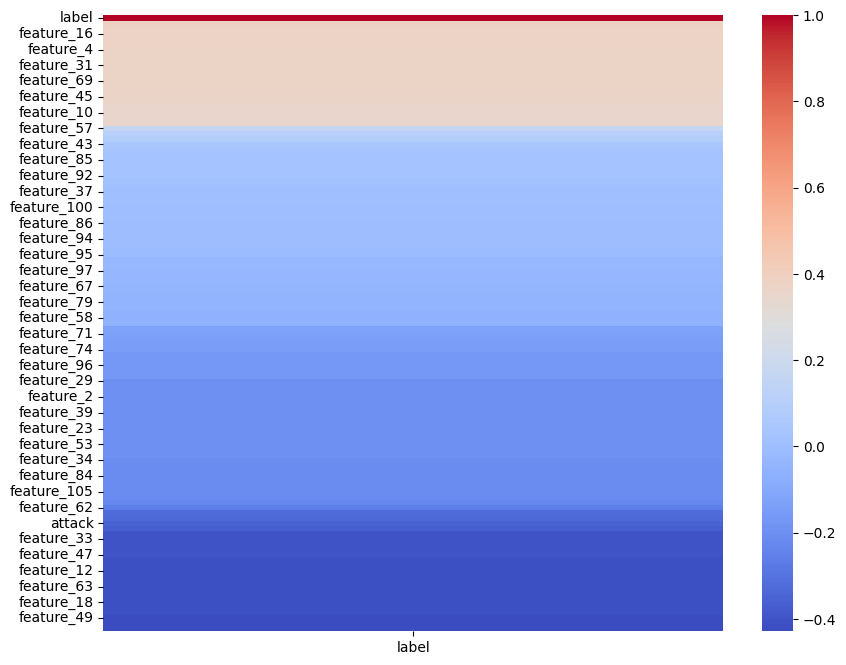

In [20]:
# correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
corr = ((df_scaled.corr().iloc[:,-1]).sort_values(ascending=False)).to_frame()
sns.heatmap(corr, cmap="coolwarm")
plt.show()

**Observation:** Below is the list of columns with low correlation with the label. ie. (-0.3 < corr < 0.3) . These are not good candidates for predictions



### SelectKBest

In [22]:
from sklearn.feature_selection import SelectKBest, f_classif

# feature selection and engineering
selector = SelectKBest(f_classif, k=50)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

**Observation:** This method is more objective and can potentially identify more relevant features than using correlation. However, it is important to choose the right value of k (number of features to select) and also to consider the possibility of overfitting.

Since in our correlation Analysis we were getting about 44 columns which were closely correlated to the label, we decided to choose a closer number, 50, as the value of k in select K best

## GridSearchCV

GridSearchCV trains and evaluates the model with all possible combinations of hyperparameters from the param_grid dictionary using cross-validation (cv=5), and returns the best set of hyperparameters that result in the highest score on the training data.

Using the best set of hyperparameters returned by GridSearchCV can potentially improve the performance of the model on unseen data. It helps to tune the model and prevent overfitting.

 * `grid_search.best_score_` returns the mean cross-validated score achieved by the best estimator found by GridSearchCV during the parameter tuning process.

This means that it returns the average performance of the model over all cross-validation folds when trained with the best hyperparameters found by the grid search. It is a useful metric to compare different models and hyperparameter settings to see which ones perform better

 * `grid_search.best_params_` returns a dictionary of the best combination of hyperparameters found by the GridSearchCV object during cross-validation. This dictionary contains the values of hyperparameters that achieved the best mean cross-validated score on the training set. These hyperparameters can then be used to instantiate and train a new model on the entire training set.

# Fit a Logistic Regression on the training dataset

This is a common classification algorithm used for binary classification problems. It is a linear model that predicts the probability of an instance belonging to the positive class. Logistic regression works well when there are no complex interactions between features.

## Tuning

In [23]:
# train and evaluate logistic regression
metrics_table = list()
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

# define the parameter grid to search over
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.1, 1.0],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 500],
}

# create an instance of the model
logreg = LogisticRegression()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, verbose=1  )

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters: {'C': 0.1, 'max_iter': 500, 'penalty': 'none', 'solver': 'newton-cg'}
Best score: 0.862088130210401


## Fit Model 1

In [24]:
# create an instance of the model with the best parameters
best_logreg =LogisticRegression(**grid_search.best_params_)

# train the model on the training data
best_logreg.fit(X_train, y_train)

# calculate predictions on Model
y_pred_logreg = best_logreg.predict(X_test)

# get the Performance metrics by method created above
metric_logreg = get_model_metrics(model_name="LogisticRegression", y_true=y_test, y_pred=y_pred_logreg)

# add metric to global list for conclusive evaluation
metrics_table.append(metric_logreg)

# display metric dictionary in df
pd.DataFrame.from_dict(metric_logreg, orient='index', columns=['Value'])

,Value
Model,LogisticRegression
Accuracy,0.854603
Precision,0.87062
Recall,0.685411
F1-Score,0.766993


### Confusion Table of Model 1

In [25]:
# confusion matrix for Logistic Regression on the training dataset
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_logreg).T)
cm.index.name = 'Predicted'
cm.columns.name = 'Actual'
cm

Actual,0,1
Predicted,,
0,3322,593
1,192,1292


# Fit a Decision Tree on the training dataset

## Tuning

In [26]:
from sklearn.tree import DecisionTreeClassifier

# define the parameter grid to search over
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# create an instance of the model
dt = DecisionTreeClassifier()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.964271536323938


## Fit Model 2

In [27]:
# create an instance of the model with the best parameters
best_dt = DecisionTreeClassifier(**grid_search.best_params_)

# train the model on the training data
best_dt.fit(X_train, y_train)

# calculate predictions on Model
y_pred_dt = best_dt.predict(X_test)

# get the Performance metrics by method created above
metric_dt = get_model_metrics(model_name="DecisionTreeClassifier", y_true=y_test, y_pred=y_pred_dt)

# add metric to global list for conclusive evaluation
metrics_table.append(metric_dt)

# display metric dictionary in df
pd.DataFrame.from_dict(metric_dt, orient='index', columns=['Value'])

,Value
Model,DecisionTreeClassifier
Accuracy,0.958881
Precision,0.915958
Recall,0.971353
F1-Score,0.942842


### Confusion Table of Model 2

In [28]:
# confusion matrix for Decision Tree on the training dataset
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_dt).T)
cm.index.name = 'Predicted'
cm.columns.name = 'Actual'
cm

Actual,0,1
Predicted,,
0,3346,54
1,168,1831


# Fit a Random Forest on the training dataset

## Tuning

In [29]:
from sklearn.ensemble import RandomForestClassifier

# define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
# create an instance of the model
rf = RandomForestClassifier()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.9699086939261612


## Fit Model 3

In [30]:
# train and evaluate the model with the best hyperparameters
best_rf = RandomForestClassifier(**grid_search.best_params_)
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)

# get the Performance metrics by method created above
metric_rf = get_model_metrics(model_name="RandomForestClassifier", y_true=y_test, y_pred = y_pred_rf)

# add metric to global list for conclusive evaluation
metrics_table.append(metric_rf)

# display metric dictionary in df
pd.DataFrame.from_dict(metric_rf, orient='index', columns=['Value'])

,Value
Model,RandomForestClassifier
Accuracy,0.970365
Precision,0.961477
Recall,0.953316
F1-Score,0.957379


### Confusion Table of Model 3

In [31]:
# confusion matrix for Random Forest on the training dataset
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_rf).T)
cm.index.name = 'Predicted'
cm.columns.name = 'Actual'
cm

Actual,0,1
Predicted,,
0,3442,88
1,72,1797


# Fit a Gradient Boosting on the training dataset

## Tuning

In [32]:
# define the parameter grid to search over
param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.1],
    'max_depth': [5],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# create an instance of the model
gb = GradientBoostingClassifier()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 0.967526796347757


## Fit Model 4

In [33]:
best_gb = GradientBoostingClassifier(**grid_search.best_params_)

# train the model on the training data
best_gb.fit(X_train, y_train)

# calculate predictions on Model
y_pred_gb = best_gb.predict(X_test)

# get the Performance metrics by method created above
metric_gb = get_model_metrics(model_name="GradientBoostingClassifier", y_true=y_test, y_pred=y_pred_gb)

# add metric to global list for conclusive evaluation
metrics_table.append(metric_gb)

# display metric dictionary in df
pd.DataFrame.from_dict(metric_gb, orient='index', columns=['Value'])

,Value
Model,GradientBoostingClassifier
Accuracy,0.964808
Precision,0.954911
Recall,0.943767
F1-Score,0.949306


### Confusion Table of Model 4

In [34]:
# confusion matrix for Gradient Boosting on the training dataset
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_gb).T)
cm.index.name = 'Predicted'
cm.columns.name = 'Actual'
cm

Actual,0,1
Predicted,,
0,3430,106
1,84,1779


# Fit a Support Vector Machine on the training dataset

## Tuning

In [35]:
from sklearn.svm import SVC

# define the parameter grid to search over
param_grid = {
    'C': [0.1, 1.0],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# create an instance of the model
svm = SVC()

# create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.783327041992159


## Fit Model 5

In [36]:
# train the model on the training data with the best hyperparameters
best_svm = SVC(**grid_search.best_params_)
best_svm.fit(X_train, y_train)

# calculate predictions on Model
y_pred_svm = best_svm.predict(X_test)

# get the Performance metrics by method created above
metric_svm = get_model_metrics(model_name="SupportVectorMachine", y_true=y_test, y_pred=y_pred_svm)

# add metric to global list for conclusive evaluation
metrics_table.append(metric_svm)

# display metric dictionary in df
pd.DataFrame.from_dict(metric_svm, orient='index', columns=['Value'])

,Value
Model,SupportVectorMachine
Accuracy,0.789405
Precision,0.716185
Recall,0.657294
F1-Score,0.685477


### Confusion Table of Model 5

In [37]:
# confusion matrix for SVM on the training dataset
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_svm).T)
cm.index.name = 'Predicted'
cm.columns.name = 'Actual'
cm

Actual,0,1
Predicted,,
0,3023,646
1,491,1239


# Fit a **kNN** on the training dataset

## Tuning

In [38]:
from sklearn.neighbors import KNeighborsClassifier

# define the parameter grid to search over
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# create a KNeighborsClassifier object
knn = KNeighborsClassifier()

# use grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# print the best hyperparameters and their corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best score: 0.928622469233823


## Fit Model 6

In [39]:
# use the best hyperparameters to train a new KNeighborsClassifier
best_knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], weights=grid_search.best_params_['weights'], p=grid_search.best_params_['p'])

# fit the model to the training data
best_knn.fit(X_train, y_train)

# make predictions on the test data
y_pred_kNN = best_knn.predict(X_test)

# get the Performance metrics by method created above
metric_kNN = get_model_metrics(model_name="K Neighbor Classifier", y_true=y_test, y_pred=y_pred_kNN)

# add metric to global list for conclusive evaluation
metrics_table.append(metric_kNN)

# display metric dictionary in df
pd.DataFrame.from_dict(metric_kNN, orient='index', columns=['Value'])

,Value
Model,K Neighbor Classifier
Accuracy,0.926468
Precision,0.879205
Recall,0.915119
F1-Score,0.896803


### Confusion Table of Model 6

In [40]:
# confusion matrix for SVM on the training dataset
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_kNN).T)
cm.index.name = 'Predicted'
cm.columns.name = 'Actual'
cm

Actual,0,1
Predicted,,
0,3277,160
1,237,1725


# Model Evaluation
When selecting a model, it is essential to consider the trade-off between model complexity and interpretability, performance, and computational resources. we can try out these models and compare their performance on a validation set using appropriate evaluation metrics such as accuracy, precision, recall, F1-score, and ROC-AUC curve. Based on the evaluation results, we can choose the best model that fits our requirements.

## Evaluation Metrics

In [41]:
# evaluate the metrics to find the best model
metric_df = pd.DataFrame(metrics_table)
metric_df

,Model,Accuracy,Precision,Recall,F1-Score
0,LogisticRegression,0.854603,0.870620,0.685411,0.766993
1,DecisionTreeClassifier,0.958881,0.915958,0.971353,0.942842
2,RandomForestClassifier,0.970365,0.961477,0.953316,0.957379
3,GradientBoostingClassifier,0.964808,0.954911,0.943767,0.949306
4,SupportVectorMachine,0.789405,0.716185,0.657294,0.685477
5,K Neighbor Classifier,0.926468,0.879205,0.915119,0.896803
